# Grundlagen der Künstlichen Intelligenz - Wintersemester 2024/25

# Übung 5: Convolutional Neural Networks

---

> 'Grundlagen der künstlichen Intelligenz' im Wintersemester 2024/2025
>
> - T.T.-Prof. Benjamin Schäfer, benjamin.schaefer@kit.edu
> - Prof. Gerhard Neumann, gerhard.neumann@kit.edu

---

In dieser Übung werden wir uns mit Convolutions und CNNs beschäftigen. Wie beim letzten Übungsblatt verwenden wir Pytorch. Zum Auffrischen könnt ihr euch folgendes Einstiegstutorial anschauen: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html, sowie das Pytorch Tutorial aus der Übung vom 06.12.24. 

## GPU Training
Im Gegensatz zum letzten Übungsblatt funktioniert das Training nur sinnvoll auf einer GPU. Wenn ihr Google Collab benutzt, könnt ihr dies auswählen, indem ihr **oben rechts auf das Dropdown Menü** ("Additional connection options") klickt:
![GPU Selection](https://i.imgur.com/dWzXhG9.png)
Geht dann auf **"Change Runtime type"** und wählt die **"T4 GPU"** aus:
![GPU Selection](https://i.imgur.com/iEUn10Y.png)
Die Session muss anschließend neu gestartet werden. Ihr habt kostenlos ein paar GPU Stunden pro Tag zur Verfügung. 

**Hinweis:** Das Training selbst wird nicht bewertet, nur eure Implementierung der Modelle. Theoretisch kann das Übungsblatt also auch ohne GPU Support gelöst werden. Allerdings könnt ihr dann die Modelle nur extrem langsam/gar nicht trainieren.

### Übungsteam

- Philipp Dahlinger, philipp.dahlinger@kit.edu
- Nicolas Schreiber, nicolas.schreiber@kit.edu
- Sebastian Pütz, sebastian.puetz@kit.edu
- Ulrich Oberhofer, ulrich.oberhofer@kit.edu


# Gruppenabgabe

Die Übungsblätter können in Gruppen von bis zu **3 Studierenden** abgegeben werden. **Jede Person aus der Gruppe muss die finale Version der Abgabe über Ilias hochladen**, es genügt nicht, dass nur eine Person aus der Gruppe dies tut. Es ist prinzipiell möglich, im Laufe des Semesters sich einer neuen Gruppe anzuschließen, sollte sich die eigene Gruppe vorzeitig auflösen. Generell muss jede Gruppe ihre eigene Lösung hochladen, wir werden die Abgaben auf Duplikate überprüfen.

Die Gruppen werden automatisch erfasst, **gebt deshalb die u-Kürzel eurer Gruppenmitglieder in die folgende Zelle ein.** Falls eure Gruppe nur aus 2 Studierenden besteht, oder ihr alleine abgibt, lasst die verbleibenden Felder frei. Hier ein Beispiel für eine Gruppe bestehend aus uabcd und uefgh:

_U-Kürzel der Gruppenmitglieder:_

_Mitglied 1: uabcd_

_Mitglied 2: uefgh_

_Mitglied 3:_


U-Kürzel der Gruppenmitglieder:

Mitglied 1:

Mitglied 2:

Mitglied 3:


# Auto-grading

Wir nutzen ein auto-grading System, welches eure abgegebenen Jupyter Notebooks automatisch analysiert und über
hidden Tests auf Richtigkeit prüft. Über diese Tests werden die Punkte bestimmt, die ihr für das Übungsblatt erhaltet.

Damit das auto-grading reibungslos funktioniert bitte folgende Dinge beachten:

- Vor dem Abgeben eines Notebooks bitte testen, dass alles von vorne bis hinten ohne Fehler durchläuft.
- Zellen, welche mit "### DO NOT CHANGE ###" markiert sind dürfen weder gelöscht noch bearbeitet werden
- Eure Lösung muss in die richtige Zelle (markiert mit "# YOUR CODE HERE") eingetragen werden.
    - (dabei natürlich den NotImplementedError löschen!)
- Es gibt potentiell scheinbar leere Zellen, die auch mit "### DO NOT CHANGE ###" markiert sind. Auch diese dürfen nicht bearbeitet oder gelöscht werden.
    - Falls dies doch gemacht wird, dann wird das automatische Grading nicht funktionieren und ihr erhaltet keine Punkte.
    - Wir werden hier strikt handeln und keine Ausnahmen machen, falls jemand doch Zellen verändert, die eindeutig als readonly markiert sind!
- Die Jupyter Notebooks haben inline Tests (für euch sichtbar), welche euer Ergebnis auf grobe Richtigkeit überprüfen.
    - Diese sind primär für euch, um Fehler zu erkennen und zu korrigieren.
    - Die inline Tests, die ihr im Notebook sehen könnt, sind allerdings nicht die Tests welche für das Grading verwendet werden!
    - Die inline Tests sind eine notwendige Bedingung, um beim Grading der Aufgabe Punkte zu erhalten!

# **WICHTIG** Abgabe des Notebooks
- Bitte das Jupyter Notebook mit dem ursprünglichen Dateinamen ins Ilias hochladen ("ex_05_cnns.ipynb")
- Bitte Jupyter Notebook und handgeschriebene PDF einzeln hochladen, nicht als ZIP.
- Bitte darauf achten, dass die Jupyter Notebook Zell-Metadaten erhalten bleiben. Das ist eigentlich immer der Fall,
in wenigen Fällen gab es hier jedoch Probleme. Um auf Nummer Sicher zu gehen bitte das Notebook vor der Abgabe ein Mal
in einem normalen Texteditor öffnen und nach "nbgrader" suchen. Wenn hier dann keine entsprechenden JSON-Einträge auftauchen
dann sind leider die Metadaten verloren gegangen.

# 1. Convolutions
In dieser Aufgabe wollen wir ein paar klassische Convolution Filter nachimplementieren. 
Diese wenden wir dann auf mehreren Beispielbildern an, und visualisieren welche Merkmale die Filter jeweils extrahieren.

In [1]:
#imports
import numpy as np
import urllib.request
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import requests
import os

grading_env_var = os.getenv('NBGRADER_EXECUTION', None)
# variable to check if notebook is in grading mode to skip trainings
is_grading = (grading_env_var == "autograde" or grading_env_var == "validate")

In [2]:
def vis_filter_pics(left_img, right_img, left_cmap='gray', right_cmap='gray', title=None):
    f, axarr = plt.subplots(1, 2, figsize=(14,4))
    f.suptitle(title)
    axarr[0].imshow(left_img, cmap=left_cmap, interpolation='nearest')    
    axarr[1].imshow(right_img, cmap=right_cmap, interpolation='nearest')
    plt.tight_layout()
    plt.show()

In [3]:
# Load the example picture
if not is_grading:
    # URL of the image
    url = "https://drive.google.com/uc?id=1MSs2afO4VEB2EezEF6zokVl4xElod8oY"

    # Download the image
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the image to a file
        with open("edge_detection_gecko.jpeg", "wb") as file:
            file.write(response.content)
        print("Image downloaded and saved as 'edge_detection_gecko.jpeg'")
    else:
        print(f"Failed to download image. Status code: {response.status_code}")

Image downloaded and saved as 'edge_detection_gecko.jpeg'


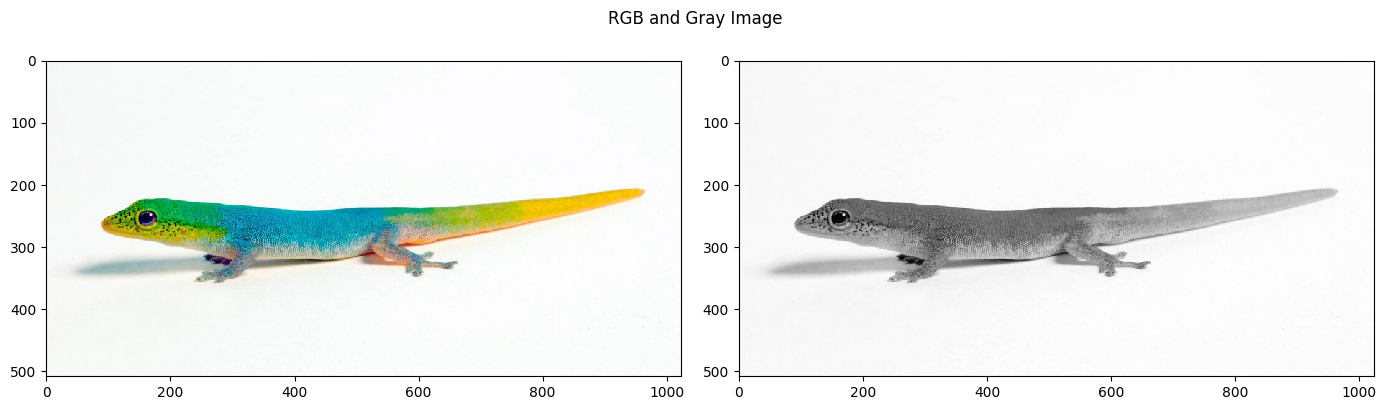

In [4]:
test_image = Image.open("edge_detection_gecko.jpeg")

# Produce a grayscaled version of that image
gray_test_image = ImageOps.grayscale(test_image)

# Convert the PIL Images to numpy arrays
test_image = np.array(test_image)
gray_test_image = np.array(gray_test_image)

vis_filter_pics(test_image, gray_test_image, title="RGB and Gray Image")

## 1.1 Implementierung einer Convolution (2 Punkte)
Als Grundlage für die späteren Kantenerkennungsaufgaben benötigen wir eine Methode, die es erlaubt, einen 2D-Convolution-Kernel auf ein Single-Channel-Bild anzuwenden.

Vervollständige dazu die Funktion convolve2D in der nächsten Zelle. Diese Funktion erhält zwei Eingabeparameter:

- `input_array`: ein 2-dimensionales numpy-Array, das ein Single-Channel-Bild repräsentiert.
- `kernel`: ein 2-dimensionales numpy-Array, das den Convolution-Kernel darstellt.
Die Funktion soll ein neues 2D-numpy-Array zurückgeben, das das Ergebnis der Convolution-Operation enthält.

Hinweise:
- Der Datentyp des `input_array` wird entweder uint oder int sein. Das Rückgabe-Array soll jedoch immer ein int32-numpy-Array sein.
- Verwende **kein Padding** (kein Hinzufügen von extra Zeilen und Spalten). Beachte dabei, dass die Ausgabe aufgrund des fehlenden Paddings eine kleinere Form (Shape) als das Eingabebild haben wird. Dies ist bei der Implementierung der Methode zu berücksichtigen.
- Nutze die Formulierung mit Cross Correlation, um die Convolution-Operation zu implementieren. (Vl. 10, Folie 19, unten)

In [5]:
def convolve2d(input_array, kernel):
    """
    Apply 2D convolution to an input array with a given kernel using simple numpy operations.
    
    Parameters:
    input_array (numpy.ndarray): 2D input array to be convolved with shape [input_height, input_width]
    kernel (numpy.ndarray): 2D convolution kernel with shape [kernel_height, kernel_width]
    
    Returns:
    np.ndarray: Result of the convolution operation
    """
    # Get dimensions
    input_height, input_width = input_array.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calculate the width and height of the output produced by the convolution
    
    ### BEGIN SOLUTION
    
    # Calculate output dimensions
    output_height = input_height - kernel_height + 1
    output_width = input_width - kernel_width + 1
    
    ### END SOLUTION
    
    # Initialize output array
    output = np.zeros((output_height, output_width), dtype=np.int32)
    
    # Implement the convolution itself
    
    ### BEGIN SOLUTION
    
    # Version 1: for vectorized convolution using array indexing
    
    # For each kernel element (i,j), shift the input array by that (i,j) offset 
    # and add its contribution (scaled by kernel[i, j]) into every corresponding element of output.
    for i in range(kernel_height):
        for j in range(kernel_width):
            output += input_array[i:i + output_height, j:j + output_width] * kernel[i, j]
    
    # Version 2:
    
    # For each output cell (i,j), sum over the local patch of input_array (of size [kernel_height,kernel_width]) 
    # multiplied by the kernel. That gives the single output pixel’s value.
    
    for i in range(output_height):
        for j in range(output_width):
            output[i, j] = (input_array[i:i+kernel_height, j:j+kernel_width] * kernel).sum()
            
    ### END SOLUTION

    return output


In [6]:
# Tests for 1.1:
test_kernel = np.array([[0, 0, 0], [0, 1, 0], [0,0,0]])
test_sample_image = np.eye(500, dtype=np.uint8)
test_convolved_image = convolve2d(test_sample_image, test_kernel)

assert test_convolved_image.dtype == np.int32
assert np.all(np.equal(test_convolved_image, np.eye(498, dtype=np.int32)))


In der nächsten Zelle haben wir einige Beispielmethoden implementiert, die jeweils einen einfachen Convolution-Kernel verwenden, um Kanten in horizontaler und vertikaler Richtung zu erkennen.

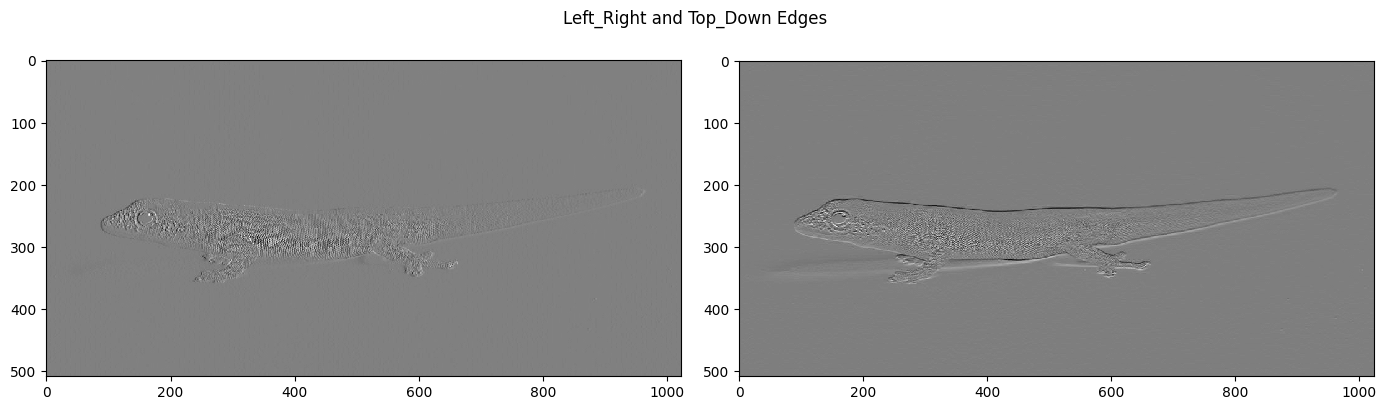

In [8]:
def left_right_edge_detection(im: np.array):
    kernel = np.array([[-1, 1]], dtype=np.int32)
    return convolve2d(im, kernel)

def top_down_edge_detection(im: np.array):
    kernel = np.array([[-1], [1]], dtype=np.int32)
    return convolve2d(im, kernel)


# Detect left_right edges and visualize them
left_right_edges = left_right_edge_detection(gray_test_image)

# Detect top_down edges and visualize them
top_down_edges = top_down_edge_detection(gray_test_image)

vis_filter_pics(left_right_edges, top_down_edges, title="Left_Right and Top_Down Edges")

## 1.2 Laplacian Convolution Kernel (1 Punkt)
In der letzten Zelle haben wir zwei einfache Convolution-Kernels implementiert, die jeweils nur horizontale oder vertikale Kanten erkennen können.

In dieser Aufgabe sollst du den Laplace-Kernel implementieren, der sowohl horizontale als auch vertikale Kanten erkennen kann. Es gibt mehrere Varianten des Laplace-Kernels. Verwende nur die Werte 0, 1 und -4 für den Kernel.

Weitere Informationen:
- Der diskrete Laplace-Kernel wird in der Bildverarbeitung verwendet, um Kanten und Regionen mit starken Intensitätsänderungen zu identifizieren.
- Er basiert auf der Berechnung der zweiten Ableitung eines Bildes, wodurch Übergänge und Kontraste hervorgehoben werden.
- Das Zentrum des Kerns erhält eine stärkere Gewichtung, die gleich der negativen Summe der Gewichte der umliegenden Elemente ist.
- Die benachbarten Werte repräsentieren die unmittelbare Umgebung des zentralen Pixels und ermöglichen eine differenzierte Betrachtung lokaler Unterschiede.
- Dieser Kernel hebt Bereiche mit plötzlichen Intensitätsänderungen hervor, indem er die Differenz zwischen dem zentralen Pixel und seinen Nachbarn analysiert.

Referenz: https://en.wikipedia.org/wiki/Discrete_Laplace_operator

In [9]:
def laplacian_edge_detection(im: np.array):
    ### BEGIN SOLUTION
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    return convolve2d(im, kernel)
    ### END SOLUTION

In [10]:
# Tests for 1.2:
test_sample_image = np.eye(500, dtype=np.uint8)
test_convolved_image = laplacian_edge_detection(test_sample_image)

assert test_convolved_image.sum() == -4

In der folgenden Zelle haben wir einige Beispielvisualisierungen vorbereitet.

Wir wenden den Laplace-Filter sowohl auf das Graustufenbild als auch auf die separaten Farbkanäle (z. B. Rot, Grün, Blau) des Bildes an. Bei korrekter Implementierung sollte ein Unterschied in den gefilterten Bildern erkennbar sein, abhängig davon, welcher Farbkanal gewählt wurde.

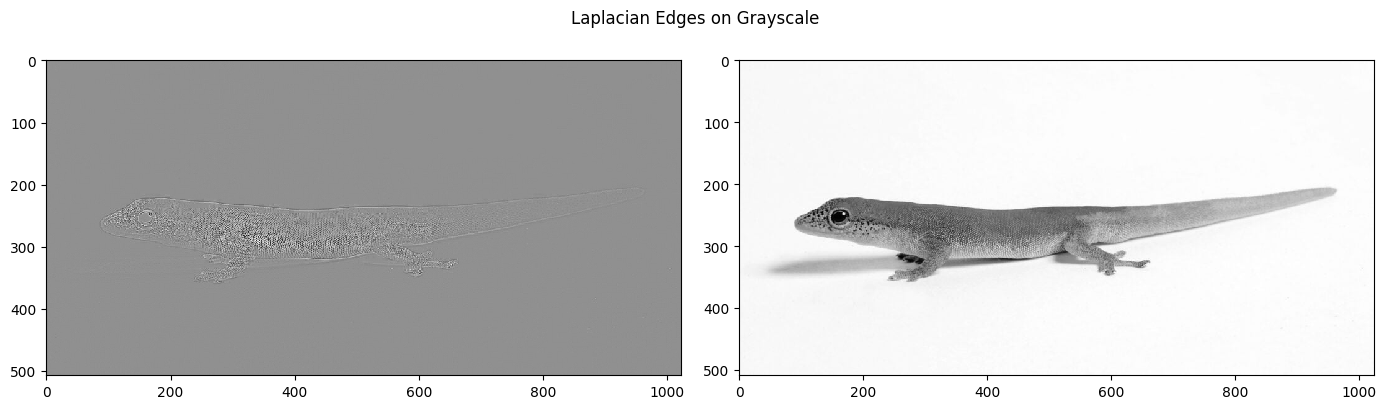

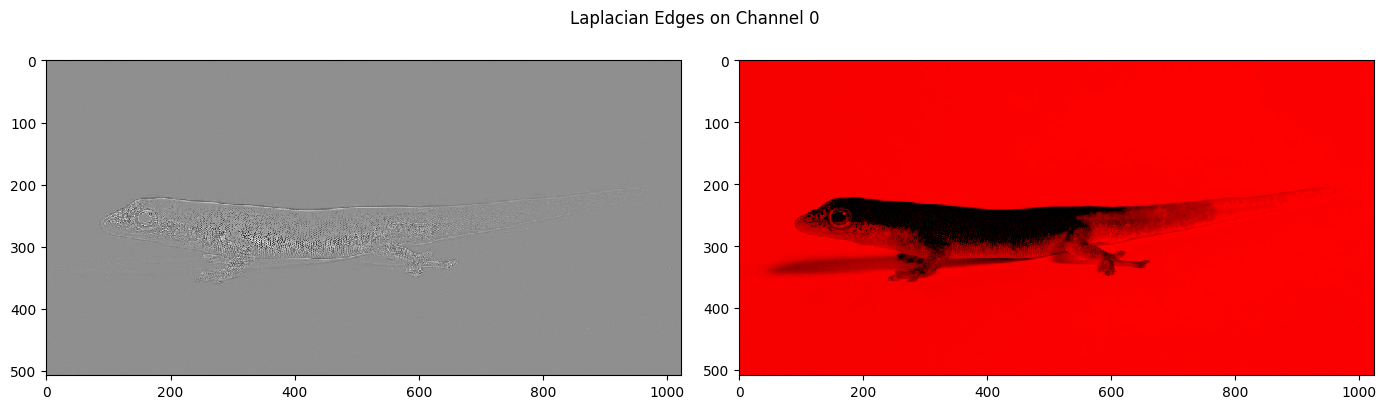

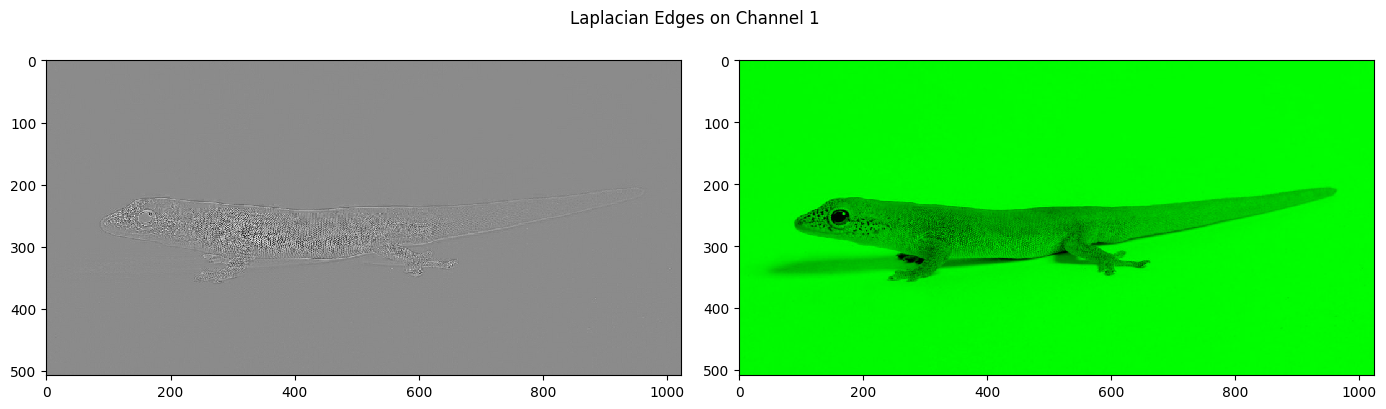

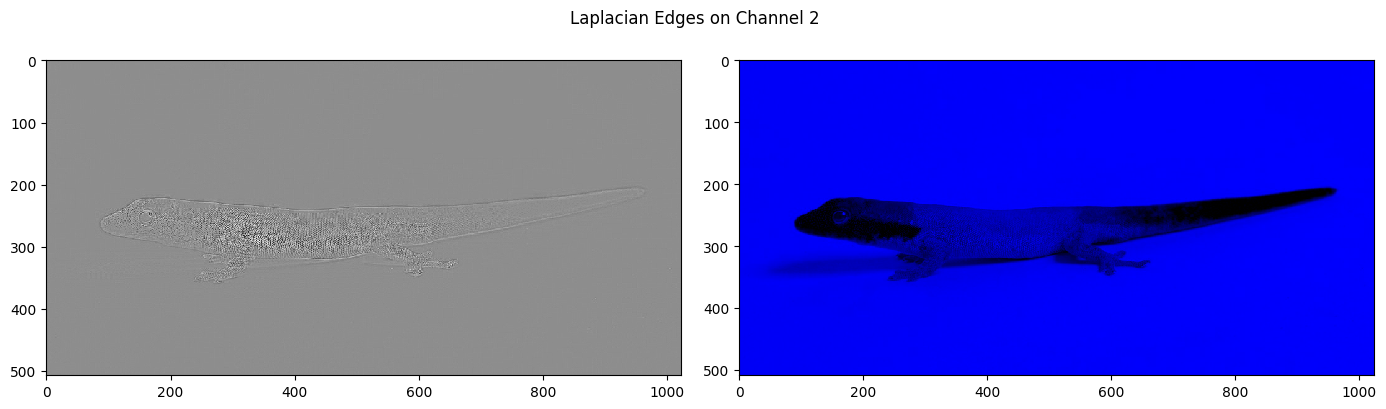

In [11]:
# Apply laplacian edge detection to grayscale image
lapl_edges = laplacian_edge_detection(gray_test_image)
vis_filter_pics(lapl_edges, gray_test_image, title="Laplacian Edges on Grayscale")

# Apply laplacian edge detection to each color channel
for i in range(test_image.shape[-1]):
    # Produce single-channel image for visualization
    single_channel_image = np.zeros_like(test_image)
    single_channel_image[:, :, i] = test_image[:, :, i]
    
    # Apply edge detection to only one of the three channels
    lapl_edges = laplacian_edge_detection(test_image[:, :, i])

    vis_filter_pics(lapl_edges, single_channel_image, title=f"Laplacian Edges on Channel {i}")

# 2. Image Classification mit CNNs
In dieser Aufgabe wollen wir verschiedene Hunde- und Katzenarten klassifizieren. Wir verwenden den "Oxford Pet Datensatz", welcher aus 37 Klassen besteht, jede Klasse eine andere Katzen/Hundeart. Wir vergleichen 3 verschiedene Architekturen: 
- Ein Multilayer Perceptron (MLP) 
- Ein simples CNN
- Ein komplexes und großes ResNet, für welches wir Transfer Learning verwenden

Zunächst laden wir den Datensatz herunter und analysieren ihn. 

In [30]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.init
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import tarfile
import urllib.request
from collections import defaultdict
from typing import Tuple
from PIL import Image

In [31]:
# Downloading the dataset, only if it does not exist already
if os.path.isdir("oxford_pet"):
    print("Dataset already downloaded")
else:
    print("Downloading dataset")

    # URLs for the dataset
    images_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    annotations_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

    # File paths
    images_tar = "oxford_pet_dataset.tar.gz"
    annotations_tar = "oxford_pet_annotations.tar.gz"
    
    # Download the dataset
    print("Downloading images...")
    urllib.request.urlretrieve(images_url, images_tar)
    print("Downloading annotations...")
    urllib.request.urlretrieve(annotations_url, annotations_tar)

    # Create the dataset directory
    os.makedirs("oxford_pet", exist_ok=True)

    # Extract the dataset
    print("Extracting images...")
    with tarfile.open(images_tar, "r:gz") as tar:
        tar.extractall(path="oxford_pet")

    print("Extracting annotations...")
    with tarfile.open(annotations_tar, "r:gz") as tar:
        tar.extractall(path="oxford_pet")

    print("Dataset downloaded and extracted successfully")


Dataset already downloaded


In [32]:
# Torch Dataset class. Parsing the structure of the provided dataset. Not too important to understand everything.
# Also, we downscale the images to 100x100 pixels.

class OxfordPetDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, target_size=(100, 100)):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.image_files = sorted(os.listdir(images_dir))
        # remove all non jpg extensions files
        self.image_files = [f for f in self.image_files if f.endswith('.jpg')]
        self.target_size = target_size
        self.transform = transforms.Compose([
          transforms.Resize(self.target_size),
          transforms.ToTensor(),
        ])
        self.all_labels = []
        self.filtered_image_files = []
        self.animal_names = set()
        with open(os.path.join(annotations_dir, "list.txt"), "r") as f:
            lines = f.readlines()
            for image_file in self.image_files:
                animal_name = image_file[:image_file.rfind("_")]
                self.animal_names.add(animal_name)
                for line in lines:
                    found_label = False
                    if animal_name in line:
                        label = int(line.split()[-3]) - 1
                        self.all_labels.append(label)
                        self.filtered_image_files.append(image_file)
                        found_label = True
                        break
                if not found_label:
                    print(f"No label found for {image_file}")
        self.image_files = self.filtered_image_files
        self.animal_names = list(self.animal_names)
        self.animal_names = [x.lower() for x in self.animal_names]
        self.animal_names.sort()


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image and corresponding annotation
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        label = self.all_labels[idx]
        # Load image and bounding boxes
        image = Image.open(img_path).convert("RGB")
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        return image, label



# Create the dataset
images_path = "oxford_pet/images"
annotations_path = "oxford_pet/annotations"
dataset = OxfordPetDataset(images_dir=images_path, annotations_dir=annotations_path, target_size=(100, 100))
# Define dataset split lengths
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # 20% for testing
animal_names = dataset.animal_names


# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataset.animal_names = dataset.animal_names  # subset does not copy attributes
test_dataset.animal_names = dataset.animal_names


## 2.1 Class Histogram (1 Punkt)
Zunächst wollen wir quantitativ den Datensatz untersuchen: Wie viele Beispiele gibt es pro Klasse? Falls eine Klasse deutlich mehr Beispiele enthält als andere, kann dies zu einem ungewünschten Bias führen.

Vervollständige dazu die Funktion `class_distribution` in der nächsten Zelle. Die Funktion erhält ein Pytorch-Dataset, sowie eine Liste von Namen der Klassen. 
Die Funktion soll ein Dictionary zurück geben, welches als Keys die Klassennamen hat, und als Values die Anzahl an Bildern dieser Klasse im Datensatz. 

*Hinweis:* 
- Iteriere über das Dataset. Das zurückgegebene Label ist ein Integer `idx`, der zugehörige Name der Klasse ist dementsprechend `animal_names[idx]`. 
- Du kannst `defaultdict` verwenden (https://www.geeksforgeeks.org/defaultdict-in-python/)

In [33]:
def class_distribution(dataset: Dataset, animal_names: list) -> dict[str, int]:
    """
    Params:
    - dataset: Pytorch Dataset class. 
    - animal_names: List of all class names.
    
    Returns: Dictionary with class names as strings and number of occurences in the dataset as values.
    """
    ### BEGIN SOLUTION
    class_occurences = defaultdict(lambda: 0)
    for (image, label) in dataset:
        class_occurences[animal_names[label]] += 1
    return class_occurences
    ### END SOLUTION

## 2.2 Class Statistics (1 Punkt)
Vervollständige nun die Funktion `class_statistics`, welche ein Tupel aus 2 Integern zurückgeben soll: die Bildanzahl der kleinsten Klasse und die Bildanzahl der größten Klasse. (Hierbei meinen wir mit kleinster/größter Klasse die Klasse mit den wenigsten/meisten Bildern)

In [34]:
def class_statistics(class_occurences: dict[str, int]) -> Tuple[int, int]:
    """
    Params:
    - class_occurences: Output of the class_distribution function
    
    Returns: The minimum and the maximum class size in the dataset. 
    """
    ### BEGIN SOLUTION
    return min(class_occurences.values()), max(class_occurences.values())
    ### END SOLUTION

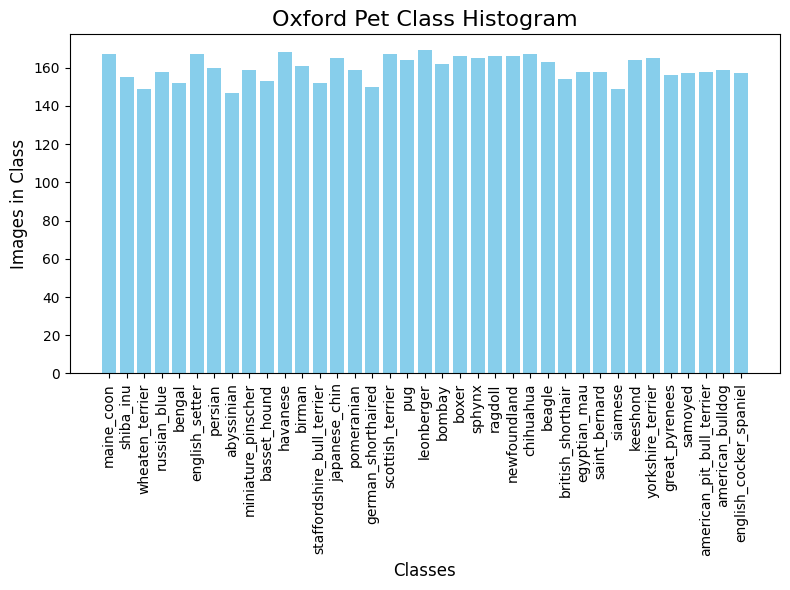

Min class size: 147
Max class size: 169


In [18]:
# Plotting of the class histogram
class_occurences = class_distribution(train_dataset, animal_names)
# Extract keys and values from the dictionary
keys = list(class_occurences.keys())
values = list(class_occurences.values())

# Create the bar plot
plt.figure(figsize=(8, 6))  
plt.bar(keys, values, color='skyblue')

# Add titles and labels
plt.title('Oxford Pet Class Histogram', fontsize=16)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Images in Class', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

stats = class_statistics(class_occurences)
print(f"Min class size: {stats[0]}")
print(f"Max class size: {stats[1]}")


Wie wir sehen, ist der Datensatz relativ ausgeglichen. Kleinere Unterschiede sind zwar vorhanden, aber das Modell sollte davon nur wenig bis gar nicht beeinflusst werden.

In [19]:
# Tests for 2.1:
class_occurences = class_distribution(train_dataset, animal_names)
assert isinstance(class_occurences, dict)
assert len(class_occurences) == 37 # numbers of classes present in the dataset


In [20]:
# Tests for 2.2
stats = class_statistics(class_occurences)
assert isinstance(stats, Tuple)
assert isinstance(stats[0], int)
assert isinstance(stats[1], int)


## Qualitative Analyse (keine Punkte)
Um einen besseren Eindruck zu bekommen, welche Bilder der Datensatz enthält, plotten wir eine Stichprobe des Datensatzs mit den jeweiligen Klassennamen. Wenn ihr die nächste Zelle mehrmals ausführt, erhaltet ihr jeweils eine neue zufällige Stichprobe.

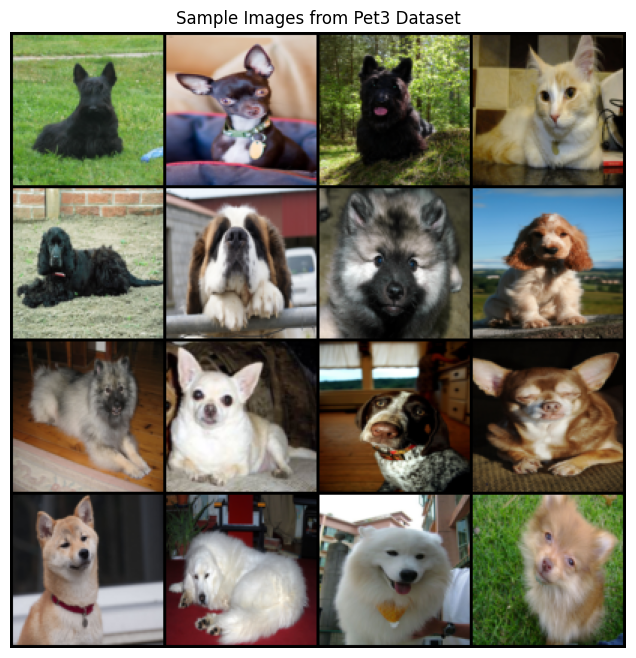

Labels:
scottish_terrier                 chihuahua                        scottish_terrier                 maine_coon                       
english_cocker_spaniel           saint_bernard                    keeshond                         english_cocker_spaniel           
keeshond                         chihuahua                        german_shorthaired               chihuahua                        
shiba_inu                        great_pyrenees                   samoyed                          pomeranian                       


In [35]:
# Create a function to display images
def show_images(dataset, num_images=16):
    # Create a DataLoader for easier batch loading
    dataloader = DataLoader(dataset, batch_size=num_images, shuffle=True)

    # Load one batch of data
    images, labels = next(iter(dataloader))
    label_names = dataset.animal_names
    # Denormalize and plot the images in a grid
    grid = make_grid(images, nrow=4, padding=2)  # 4x4 grid of images
    np_grid = grid.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))  # Change from CHW to HWC
    plt.title("Sample Images from Pet3 Dataset")
    plt.axis("off")
    plt.show()
    print("Labels:")
    for i in range(len(labels) // 4):
        result = ""
        for j in range(4):
            result += f"{label_names[labels[i * 4 + j].item()]: <32} "
        print(result)


show_images(train_dataset)

## 2.3 Baseline MLP Implementierung (2 Punkte)

Als erstes Modell wollen wir ein Standard Feedforward Netzwerk/MLP implementieren. 
Dazu werden die Bilder mit shape (3, 100,100) (da 3 Channel RGB) als ein langes Array interpretiert mit `input_shape=100*100*3`.
Das Netzwerk soll folgende Layers enthalten:
- ein Linear Layer, welches Tensoren von Größe `input_size` auf Tensoren der Größe `512` abbildet.
- eine ReLU Activation
- ein Linear Layer, welches Tensoren von Größe `512` auf Tensoren der Größe `256` abbildet.
- eine ReLU Activation
- ein Linear Layer, welches Tensoren von Größe `256` auf Tensoren der Größe `num_classes` abbildet.

Implementiere diese Struktur, indem du die Liste `layers` korrekt befüllst. 

Implementiere anschließend den Forward Pass durch das Netzwerk. 

*Hinweis:* Im Forward Pass ist `x` ein Tensor mit Größe `(batch_size, 3, 100, 100)` Denke daran, zunächst das Bild in einen Tensor der Größe `(batch_size, 100*100*3)` umzuwandeln. Du kannst dafür die Funktion `x.view(...)` verwenden.

In [36]:
class BaselineMLP(nn.Module):
    def __init__(self, input_size=100*100*3, num_classes=37):
        super(BaselineMLP, self).__init__()
        # Define a sequential model with fully connected layers
        layers = []
        ### BEGIN SOLUTION
        layers.append(nn.Linear(input_size, 512))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(512, 256))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(256, num_classes))
        ### END SOLUTION
        # Create a Sequential model which you should use in the Forward pass
        self.model = nn.Sequential(*layers)
        self.mlp_layers = layers

    def forward(self, x):
        ### BEGIN SOLUTION
        x = x.view(x.size(0), -1)
        x = self.model(x)
        ### END SOLUTION
        return x

In [37]:
# Test 2.3
mlp = BaselineMLP(input_size=100*100*3, num_classes=37)
assert len(mlp.mlp_layers) == 5, "Fehlende oder zu viele Linear-Layers."
layers = list(mlp.mlp_layers)
assert isinstance(layers[0], nn.Linear), "Fehler im ersten Linear-Layer."
assert isinstance(layers[1], nn.ReLU), "Fehlendes ReLU nach dem ersten Layer."
assert isinstance(layers[2], nn.Linear), "Fehler im zweiten Linear-Layer."
assert isinstance(layers[3], nn.ReLU), "Fehlendes ReLU nach dem zweiten Layer."
assert isinstance(layers[4], nn.Linear), "Fehler im dritten Linear-Layer."
mlp_params = sum(param.numel() for param in mlp.parameters())
assert mlp_params == 15501349


### BEGIN HIDDEN TESTS
assert layers[0].in_features == 100*100*3
assert layers[0].out_features == 512

assert layers[2].in_features == 512
assert layers[2].out_features == 256

assert layers[4].in_features == 256
assert layers[4].out_features == 37
### END HIDDEN TESTS

In [24]:
# Hidden tests, do not remove


## 2.4 Evaluierung (2 Punkte)
Bevor wir das erste Modell trainieren, sollten wir uns Gedanken um die Evaluierung machen. Um das MLP Modell mit anderen Modellen zu vergleichen und die Performanz zu testen, muss es auf ungesehenen Testdaten evaluiert werden. 2 Metriken haben sich für Multi-Klassifikationsaufgaben als besonders relevant erwiesen:
- Accuracy: Wie viel Prozent der Testbilder wurden korrekt klassifiziert?
- Top-5 Accuracy: Wie oft prädiziert das Modell die korrekte Klasse unter den fünf wahrscheinlichsten Vorhersagen? Bei einem Neuronalen Netzwerk erhalten wir als Output ein Tensor mit Scores pro Klasse. Ist die richtige Klasse unter den 5 Klassen mit den höchsten Scores dabei, zählen wir in der Top-5 Accuracy das Bild als richtig klassifiziert.

Implementiere beide Metriken für einen Batch von Outputs und Labels. Vervollständige dazu die Funktionen in der nächsten Zelle.

*Hinweise:*
- `torch.max(...)` (https://pytorch.org/docs/main/generated/torch.max.html) sowie `torch.topk(...)` (https://pytorch.org/docs/stable/generated/torch.topk.html#torch.topk) könnten hier relevant sein. 
- Beachte, dass beide Tensoren in der Trainingsloop auf der GPU sind. Falls du komplett neue Tensoren (z.B. mittels `example = torch.zero(..)` definierst, rufe `example.to(outputs.device)` auf. Dies schiebt den Tensor auf das gleiche Device wie das Device von `outputs`.
- Um aus einem skalarwertigen Tensor `result` ein `int` zu erhalten, verwende die Methode `result.item()`.


In [38]:
def get_correct_per_batch(outputs: torch.Tensor, labels: torch.Tensor) -> int:
    """
    Given a batch of outputs of the network and ground-truth labels, compute how many of the outputs are predicted 
    correctly. We define the prediction of the network as the argmax of the outputs. 
    params:
    - outputs: tensor of shape (batch_size, num_classes). contains per image in the batch the predicted scores. 
            torch dtype: float32
    - labels: tensor of shape (batch_size). Contains per image in the batch the index of the correct class. 
            torch dtype: int64
    
    Returns: Integer between 0 and batch_size. Returns the number of correctly classified images in the batch.
    """
    ### BEGIN SOLUTION
    _, predicted = torch.max(outputs, 1)
    return (predicted == labels).sum().item()
    ### END SOLUTION

def get_top_5_correct_per_batch(outputs: torch.Tensor, labels: torch.Tensor) -> int:
    """
    Computes the number of correct predictions in the Top-5 Accuracy metric for a given batch. 
    The goal is to determine how many samples have their true label included among the top 5 predicted classes ranked by the model's scores.
    params:
    - outputs: tensor of shape (batch_size, num_classes). contains per image in the batch the predicted scores. 
            torch dtype: float32
    - labels: tensor of shape (batch_size). Contains per image in the batch the index of the correct class. 
            torch dtype: int64
    
    Returns: Integer between 0 and batch_size. Returns the number of correctly top-5 classified images in the batch.
    """
    ### BEGIN SOLUTION
    _, top5_predictions = outputs.topk(5, dim=1)  # Shape: (batch_size, 5)
    labels_expanded = labels.view(-1, 1)  # Shape: (batch_size, 1)
    return (top5_predictions == labels_expanded).any(dim=1).sum().item()
    ### END SOLUTION

In [39]:
# Test für 2.4a Accuracy
dummy_output = torch.tensor([[2., 1., 3., 4.], 
                             [0., 0., 1., 0.], 
                             [-2., 5., 1., 1.], 
                             [6., 1., 3., 4.], 
                             [0., 2., 1., 0.], 
                             [-2., -3., 3., 1.]])
dummy_labels = torch.tensor([3, 3, 1, 2, 1, 2])  # right, wrong, right, wrong, right, right -> Result should be 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# put to GPU if available
dummy_output = dummy_output.to(device)
dummy_labels = dummy_labels.to(device)
num_correct = get_correct_per_batch(dummy_output, dummy_labels)
assert isinstance(num_correct, int)
assert 0 <= num_correct
assert num_correct <= len(dummy_labels)
assert num_correct == 4

In [40]:
# Test für 2.4b top5
dummy_output = torch.tensor([[0.,1,2,3,4,5,6,7,8,9], 
                             [0.,1,2,3,4,5,6,7,8,9], 
                             [0.,1,2,3,4,5,6,7,8,9],
                             [0.,1,2,3,4,5,6,7,8,9],
                             [0.,1,2,3,4,5,6,7,8,9],
                             [0.,1,2,3,4,5,6,7,8,9],
                             [0.,1,2,3,4,5,6,7,8,9],
                             [0.,1,2,3,4,5,6,7,8,9],
                             [0.,1,2,3,4,5,6,7,8,9],
                             [0.,1,2,3,4,5,6,7,8,9],
                             [9.,8,7,6,5,0,1,2,3,4],
                             [9.,8,7,6,5,0,1,2,3,4],
                             [9.,8,7,6,5,0,1,2,3,4],
                             [9.,8,7,6,5,0,1,2,3,4],
                             [9.,8,7,6,5,0,1,2,3,4],
                             [9.,8,7,6,5,0,1,2,3,4],
                             [9.,8,7,6,5,0,1,2,3,4],
                             [9.,8,7,6,5,0,1,2,3,4],
                             [9.,8,7,6,5,0,1,2,3,4],
                             [9.,8,7,6,5,0,1,2,3,4]])
dummy_labels = torch.tensor([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9]) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# put to GPU if available
dummy_output = dummy_output.to(device)
dummy_labels = dummy_labels.to(device)
num_correct = get_top_5_correct_per_batch(dummy_output, dummy_labels)
assert isinstance(num_correct, int)
assert 0 <= num_correct
assert num_correct <= len(dummy_labels)
assert num_correct == 10


## Training des MLPs (keine Punkte)
Nun können wir unser erstes Modell trainieren. Hierfür verwenden wir den Code in der nächsten Zelle. Der Aufruf ist in der Zelle danach. Nach jeder Epoche evaluieren wir die Accuracy. Außerdem berechnen wir am Ende des Trainings eine Confusion Matrix. Diese zeigt, welche Klassen wie oft für eine andere Klasse verwechselt wurden. Idealerweise sollte diese Matrix eine pefekte Diagonalmatrix sein. Du solltest eine Accuracy von ca. 10-11% erhalten. 

In [41]:
def train_and_evaluate(model, num_epochs, device, lr=0.0001):
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) 
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Test loader
    print(f"Using Device: {device}")

    criterion = nn.CrossEntropyLoss()  # Loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Optimizer
    
    for epoch in range(num_epochs):
        t0 = time.time()
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)  # Move data to device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()
        t1 = time.time()
        # Print epoch statistics
        print(f"------------------------\nEpoch [{epoch+1}/{num_epochs}] took {t1 - t0:.2f} seconds.\nTrain Loss: {running_loss / len(train_loader):.4f}")
        evaluate(model, test_loader, criterion, device)


def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    top5_correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device

            # Forward pass
            outputs = model(images)
            #torch.set_printoptions(edgeitems=None, linewidth=200, threshold=10000)
            #print("----------")
            #print(outputs)
            #print(labels)
            # Update counts
            try:
                top5_correct += get_top_5_correct_per_batch(outputs, labels)
                # print("top_5", top5_correct)
            except Exception:
                # Something went wrong in the computation of the top_5 computation. Skip this metric.
                pass
            try:
                correct += get_correct_per_batch(outputs, labels)
                # print("correct", correct)
            except Exception:
                # Something went wrong in the computation of the accuracy. Skip this metric.
                pass
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total += labels.size(0)


    # Calculate accuracy and average loss
    accuracy = 100 * correct / total
    top_5_accuracy = 100 * top5_correct / total
    avg_loss = total_loss / len(test_loader)

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Top-5 Accuracy: {top_5_accuracy:.2f}%")
    print(f"Test Loss: {avg_loss:.4f}")
    
def show_images_with_predictions(dataset, model, num_images=16, device='cpu'):
    import torch
    from torchvision.utils import make_grid
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    import numpy as np
    import math

    sqrt_n = math.isqrt(num_images)
    num_images = sqrt_n ** 2

    # Ensure model is in evaluation mode
    model.to(device)
    model.eval()

    # Label names
    label_names = dataset.animal_names



    # Create a DataLoader for easier batch loading
    dataloader = DataLoader(dataset, batch_size=num_images, shuffle=True)

    # Load one batch of data
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)


    # Create grid of images
    grid = make_grid(images.cpu(), nrow=sqrt_n, padding=2)  #grid of images
    np_grid = grid.numpy()

    # Display the images
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))  # Change from CHW to HWC
    plt.title("Sample Images from Oxford Pet3")
    plt.axis("off")
    plt.show()

    # Print labels
    print("Labels (True | Predicted):")
    for i in range(len(labels) // sqrt_n):
        result = ""
        for j in range(sqrt_n):
            idx = i * sqrt_n + j
            true_label = label_names[labels[idx].item()]
            pred_label = label_names[predicted_labels[idx].item()]
            result += f"{true_label[:8]:<10} | {pred_label[:8]:<12} "
        print(result)
        
def plot_confusion_matrix(dataset, model, names, device):
    test_loader = DataLoader(dataset, batch_size=32, shuffle=False)  # Test loader
    model.to(device)
    model.eval()
    gth = []
    pred = []
    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            gth.append(labels)
            pred.append(predicted)
    
    gth = torch.cat(gth).cpu().numpy()
    pred = torch.cat(pred).cpu().numpy()
    
    # Get the number of classes
    num_classes = len(names)

    # Initialize the confusion matrix with zeros
    cm = np.zeros((num_classes, num_classes), dtype=int)

    # Populate the confusion matrix
    for true, pred_label in zip(gth, pred):
        cm[true, pred_label] += 1

    # Plotting the confusion matrix
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Display the matrix as an image
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Add color bar
    plt.colorbar()

    # Set tick marks and labels using class names
    plt.xticks(np.arange(num_classes), names, rotation=90)
    plt.yticks(np.arange(num_classes), names)

    # Annotate the cells with the confusion matrix values
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    # Layout adjustments
    plt.tight_layout()
    plt.show()

Using Device: cuda
------------------------
Epoch [1/10] took 6.80 seconds.
Train Loss: 3.5592
Test Accuracy: 4.94%
Test Top-5 Accuracy: 23.07%
Test Loss: 3.4748
------------------------
Epoch [2/10] took 6.55 seconds.
Train Loss: 3.4442
Test Accuracy: 6.29%
Test Top-5 Accuracy: 28.35%
Test Loss: 3.4186
------------------------
Epoch [3/10] took 6.42 seconds.
Train Loss: 3.3842
Test Accuracy: 8.93%
Test Top-5 Accuracy: 30.72%
Test Loss: 3.3636
------------------------
Epoch [4/10] took 6.46 seconds.
Train Loss: 3.3368
Test Accuracy: 8.73%
Test Top-5 Accuracy: 33.76%
Test Loss: 3.3348
------------------------
Epoch [5/10] took 6.39 seconds.
Train Loss: 3.2883
Test Accuracy: 10.96%
Test Top-5 Accuracy: 35.25%
Test Loss: 3.3018
------------------------
Epoch [6/10] took 6.52 seconds.
Train Loss: 3.2454
Test Accuracy: 10.76%
Test Top-5 Accuracy: 37.21%
Test Loss: 3.2603
------------------------
Epoch [7/10] took 6.51 seconds.
Train Loss: 3.2041
Test Accuracy: 11.30%
Test Top-5 Accuracy: 38

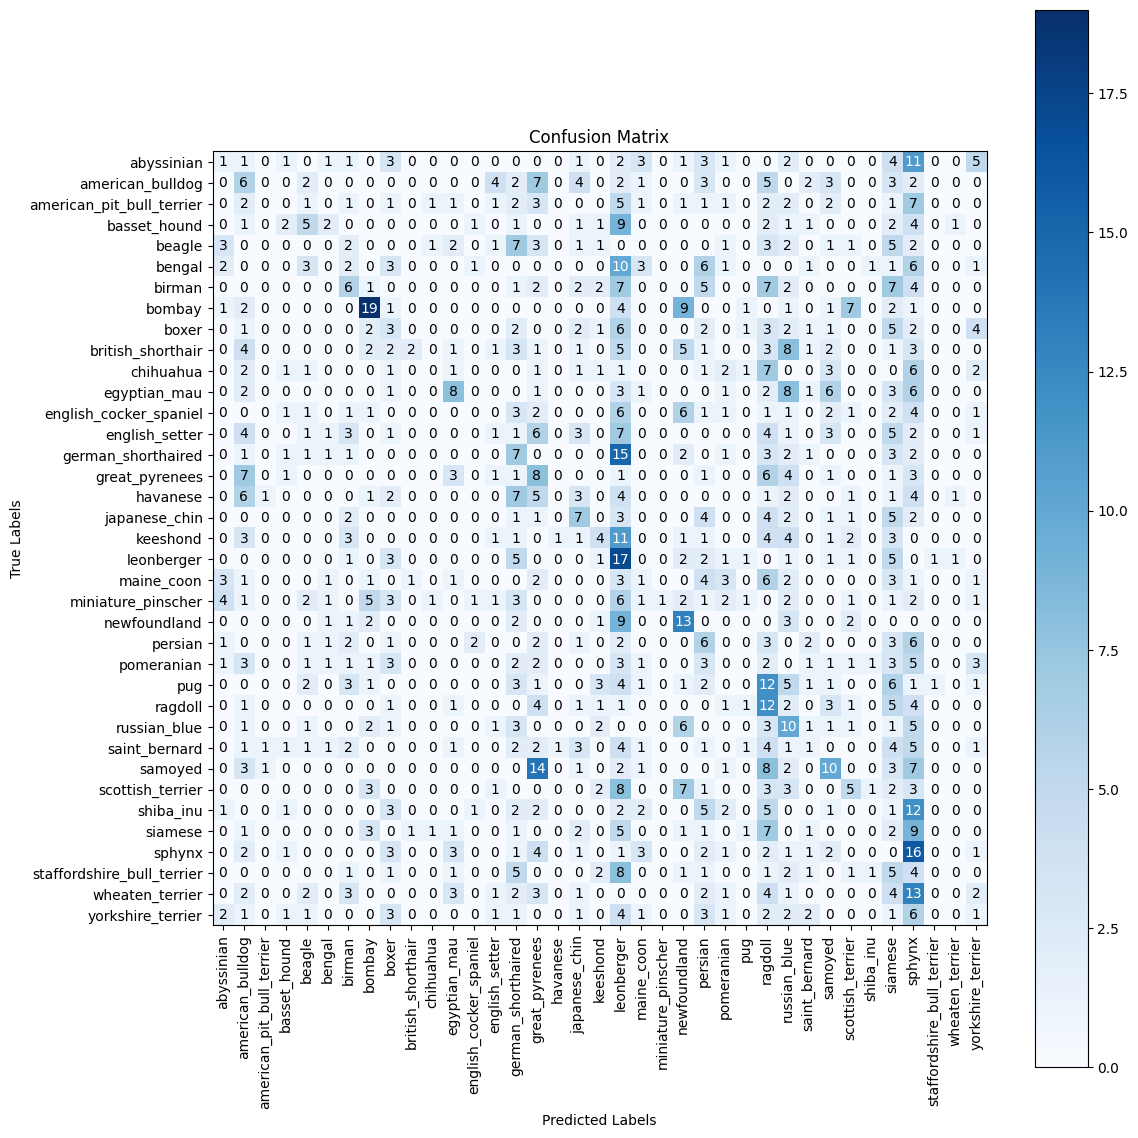

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
mlp = BaselineMLP(num_classes=37).to(device)
# Falls ihr hier etwas ändert, bitte darauf achten, dass diese If-Abfrage nicht entfernt wird.
# Ansonsten wird das auto-grading zu lange dauern und abbrechen.
if not is_grading:
    train_and_evaluate(mlp, num_epochs=10, device=device, lr=0.0001)
    plot_confusion_matrix(test_dataset, mlp, animal_names, device)

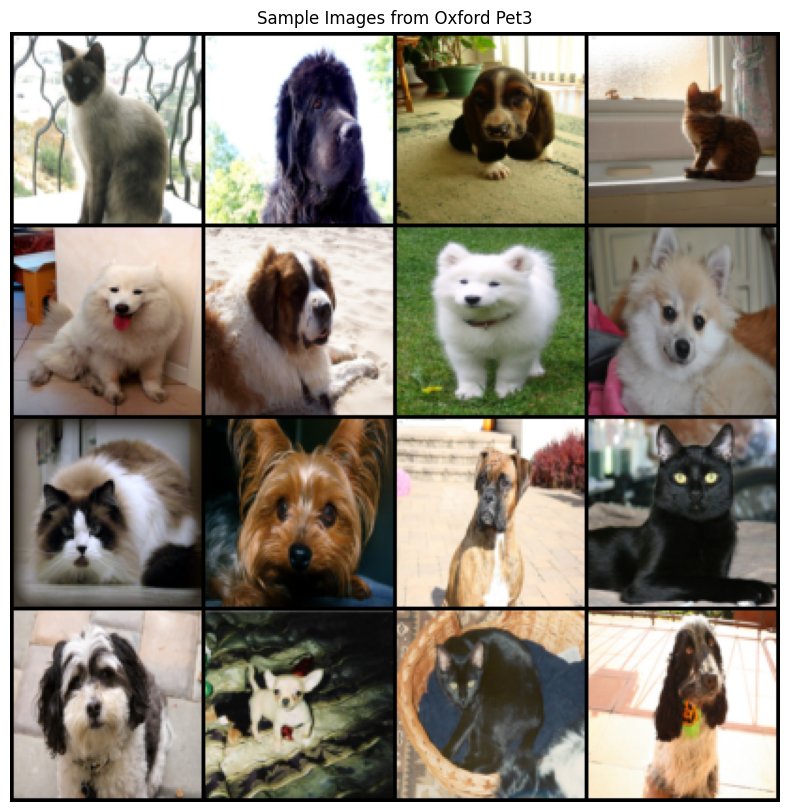

Labels (True | Predicted):
siamese    | newfound     newfound   | newfound     basset_h   | leonberg     bengal     | sphynx       
samoyed    | sphynx       saint_be   | leonberg     samoyed    | great_py     pomerani   | american     
ragdoll    | great_py     yorkshir   | sphynx       boxer      | siamese      bombay     | bombay       
havanese   | leonberg     chihuahu   | ragdoll      bombay     | bombay       english_   | leonberg     


In [45]:
# Qualitative results, restart this cell for different results
show_images_with_predictions(test_dataset, mlp, num_images=16)

## 2.5 CNN Implementierung (2 Punkte)
Nun wollen wir vergleichen, wie gut ein CNN abschneidet. 

Implementiere den "Feature Extractor" Teil, welcher aus folgenden Convolution Layers, Activation Layers und Pooling Layers besteht:
- Convolution, in_channels: **3**, out_channels: **32**, kernel_size: **5**, stride: 1, padding: **2**
- ReLU Activation 
- Max Pooling, kernel_size: 2, stride: 2
<br>
  
- Convolution, in_channels: **32**, out_channels: **64**, kernel_size: **3**, stride: 1, padding: **1**
- ReLU Activation
- Max Pooling, kernel_size: 2, stride: 2
<br>
  
  
- Convolution, in_channels: **64**, out_channels: **128**, kernel_size: 3, stride: 1, padding: 1
- ReLU Activation
- Max Pooling, kernel_size: 2, stride: 2
<br>  
  
  
- Convolution, in_channels: **128**, out_channels: **256**, kernel_size: 3, stride: 1, padding: 1
- ReLU Activation
- Max Pooling, kernel_size: 2, stride: 2

Implementiere diese Struktur, indem du die Liste `feature_extractor_layers` korrekt befüllst. 

Anschließend wird im Forward pass der Output vom Feature Extractor "flattened", sodass der resultierende Tensor Shape `(batch_size, 256 * final_img_size * final_img_size)` hat. Überlege, welche Größe `final_img_size` hat. Beachte, dass bei ungeraden Bildgrößen die MaxPool Layer abrundet. Implentiere anschließend die Layers vom Classifier:

- Fully Connected, in_features: 256 * final_img_size * final_img_size, out_features: 128
- ReLU Activation
- Fully Connected, in_features: 128, out_features: `num_classes`

Den Forward Pass haben wir bei diesem Netzwerk schon gegeben.

*Hinweise:*
- Verwende für die Convolutions die Implementierung `torch.nn.Conv2d` (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Lasse nicht gegebene Argumente wie `groups` oder `padding_mode` beim Default Wert.
- Verwende für die Max Pooling Layers die Implementierung `torch.nn.MaxPool2d`(https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).

In [46]:
class CNN(nn.Module):
    def __init__(self, num_classes=37):  
        super().__init__()
        feature_extractor_layers = []
        ### BEGIN SOLUTION
        feature_extractor_layers.append(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)) # Output: 32x100x100
        feature_extractor_layers.append(nn.ReLU())
        feature_extractor_layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # Output: 32x50x50
        
        feature_extractor_layers.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1))
        feature_extractor_layers.append(nn.ReLU())
        feature_extractor_layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # Output: 64x25x25
        
        feature_extractor_layers.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1))
        feature_extractor_layers.append(nn.ReLU()) 
        feature_extractor_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))# Output: 128x12x12
        
        feature_extractor_layers.append(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1))
        feature_extractor_layers.append(nn.ReLU())
        feature_extractor_layers.append(nn.MaxPool2d(kernel_size=2, stride=2)) # Output: 256x6x6
        ### END SOLUTION
        self.feature_extractor = nn.Sequential(*feature_extractor_layers)
        self.feature_extractor_layers = feature_extractor_layers
        
        classifier_layers = []
        ### BEGIN SOLUTION
        classifier_layers.append(nn.Linear(256 * 6 * 6, 128))
        classifier_layers.append(nn.ReLU())
        classifier_layers.append(nn.Linear(128, num_classes))
        ### END SOLUTION
        self.classifier = nn.Sequential(*classifier_layers)
        self.classifier_layers = classifier_layers
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)  # Flatten feature maps into vectors
        x = self.classifier(x)
        return x

In [47]:
# Test für 2.5
cnn = CNN(num_classes=37)
# ----- Feature Extraction -----
assert len(cnn.feature_extractor_layers) == 12, "Fehlende oder zu viele Feature-Extractor-Layers."
layers = list(cnn.feature_extractor_layers)
assert isinstance(layers[0], nn.Conv2d), "Fehler im ersten Convolution-Layer."
assert isinstance(layers[1], nn.ReLU), "Fehlendes ReLU nach der ersten Convolution."
assert isinstance(layers[2], nn.MaxPool2d), "Fehler im MaxPool-Layer nach der ersten Convolution."

assert isinstance(layers[3], nn.Conv2d), "Fehler im zweiten Convolution-Layer."
assert isinstance(layers[4], nn.ReLU), "Fehlendes ReLU nach der ersten Convolution."
assert isinstance(layers[5], nn.MaxPool2d), "Fehler im MaxPool-Layer nach der zweiten Convolution."

assert isinstance(layers[6], nn.Conv2d), "Fehler im dritten Convolution-Layer."
assert isinstance(layers[7], nn.ReLU), "Fehlendes ReLU nach der ersten Convolution."
assert isinstance(layers[8], nn.MaxPool2d), "Fehler im MaxPool-Layer nach der dritten Convolution."

assert isinstance(layers[9], nn.Conv2d), "Fehler im vierten Convolution-Layer."
assert isinstance(layers[10], nn.ReLU), "Fehlendes ReLU nach der ersten Convolution."
assert isinstance(layers[11], nn.MaxPool2d), "Fehler im MaxPool-Layer nach der vierten Convolution."

# ----- Classifier -----
assert len(cnn.classifier_layers) == 3, "Fehlende oder zu viele Classifier-Layers."
layers = list(cnn.classifier_layers)
assert isinstance(layers[0], nn.Linear), "Fehler im ersten Linear-Layer."
assert isinstance(layers[1], nn.ReLU), "Fehlendes ReLU nach dem ersten Layer."
assert isinstance(layers[2], nn.Linear), "Fehler im zweiten Linear-Layer."

# ------- Total Parameters --------
cnn_params = sum(param.numel() for param in cnn.parameters())
assert cnn_params == 1574501



## Training des CNNs (keine Punkte)
Führe die nächste Zelle aus, um das CNN zu trainineren. Du solltest eine höhere Accuracy erhalten als das MLP (Um die 20%).

Using Device: cuda
------------------------
Epoch [1/10] took 6.69 seconds.
Train Loss: 3.6056
Test Accuracy: 6.77%
Test Top-5 Accuracy: 22.53%
Test Loss: 3.5603
------------------------
Epoch [2/10] took 6.68 seconds.
Train Loss: 3.4247
Test Accuracy: 9.68%
Test Top-5 Accuracy: 36.87%
Test Loss: 3.2650
------------------------
Epoch [3/10] took 6.58 seconds.
Train Loss: 3.2184
Test Accuracy: 13.06%
Test Top-5 Accuracy: 40.80%
Test Loss: 3.1600
------------------------
Epoch [4/10] took 6.71 seconds.
Train Loss: 3.1168
Test Accuracy: 13.67%
Test Top-5 Accuracy: 43.17%
Test Loss: 3.1048
------------------------
Epoch [5/10] took 6.61 seconds.
Train Loss: 3.0229
Test Accuracy: 15.70%
Test Top-5 Accuracy: 44.99%
Test Loss: 3.0631
------------------------
Epoch [6/10] took 6.72 seconds.
Train Loss: 2.9413
Test Accuracy: 16.17%
Test Top-5 Accuracy: 50.07%
Test Loss: 3.0054
------------------------
Epoch [7/10] took 6.62 seconds.
Train Loss: 2.8734
Test Accuracy: 15.70%
Test Top-5 Accuracy: 

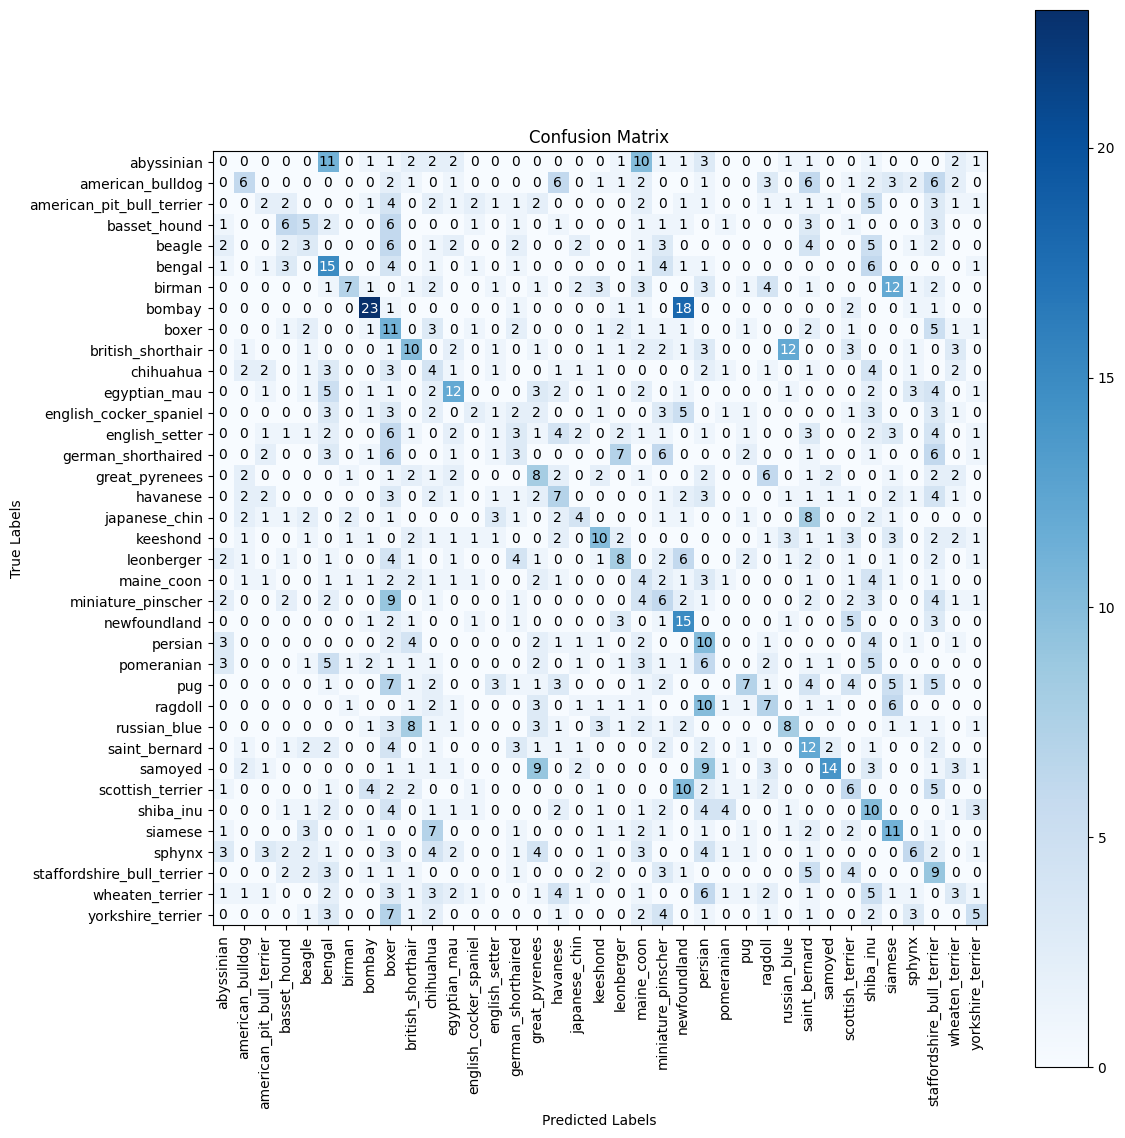

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
cnn = CNN(num_classes=37).to(device)
# Falls ihr hier etwas ändert, bitte darauf achten, dass diese If-Abfrage nicht entfernt wird.
# Ansonsten wird das auto-grading zu lange dauern und abbrechen.
if not is_grading:
    train_and_evaluate(cnn, num_epochs=10, device=device, lr=0.0001)
    plot_confusion_matrix(test_dataset, cnn, animal_names, device)

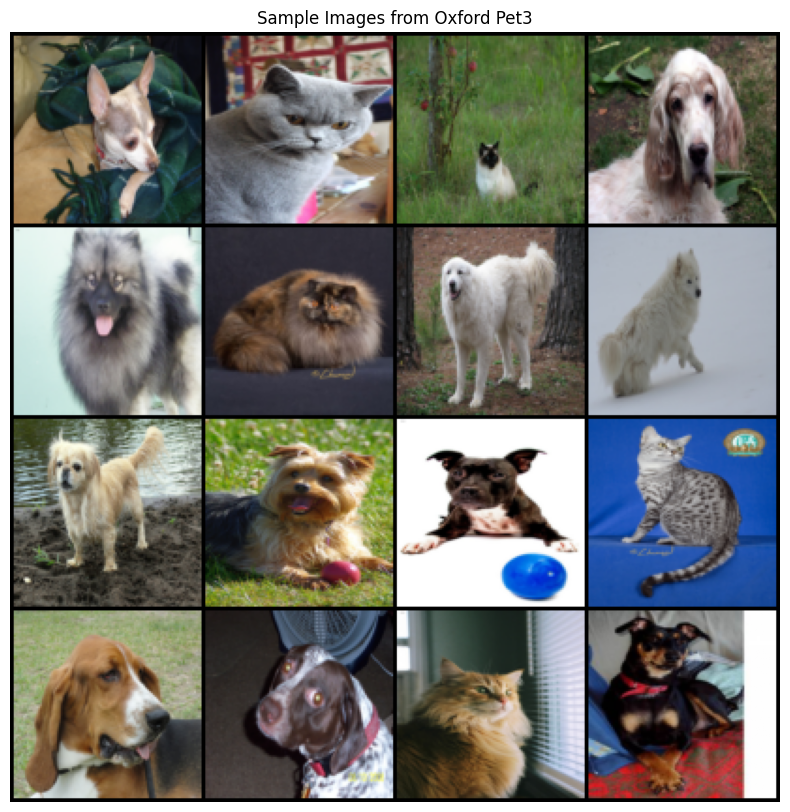

Labels (True | Predicted):
chihuahu   | sphynx       british_   | keeshond     birman     | stafford     english_   | stafford     
keeshond   | british_     persian    | maine_co     great_py   | samoyed      samoyed    | persian      
japanese   | shiba_in     yorkshir   | yorkshir     stafford   | miniatur     egyptian   | egyptian     
basset_h   | abyssini     german_s   | american     maine_co   | shiba_in     miniatur   | miniatur     


In [49]:
# Qualitative results, restart this cell for different results
show_images_with_predictions(test_dataset, cnn, num_images=16)

## 2.6 Fine-Tuning eines ResNets ( 1 Punkt)
Obwohl die Performance des CNNs besser ist als die des MLPs, ist die maximale Top-5 Accuracy des CNNs nur bei ca. 50%. Längeres Training könnte hier helfen, allerdings wird dann die Gefahr von Overfitting größer. Um den Task gut zu lösen, benötigen wir mehr Daten und größere Netzwerke. Deshalb wollen wir in dieser letzten Aufgabe ein ResNet mithilfe von Fine-Tuning trainieren.

Pytorch hat eine größere Ansammlung an Modellen, welche auf größeren Datensätzen (bspw. ImageNet: https://de.wikipedia.org/wiki/ImageNet) vortrainiert wurden. 
Wir können solch ein Modell und dessen vortrainierten Gewichte laden, und anschließend die letzte Layer anpassen, sodass das Modell Vorhersagen für unser Datensatz mit 37 unterschiedlichen Klassen macht.

Vervollständige dazu die Funktion `get_resnet`, welche ein vortrainiertes ResNet lädt und anschließend die letzte Layer anpassen soll.

*Hinweise:*
- Die letzte Layer des ResNets ist gespeichert unter `resnet.fc`. Ersetze diese durch ein `torch.nn.Linear` Layer mit korrekten `in_features` und `out_features`. 
- Die ursprünglichen `in_features` erhältst du über `resnet.fc.in_features`, bevor du die Layer ersetzt.

In [50]:
def get_resnet(num_classes=37):
    resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)  # load the resnet with pretrained weights
    ### BEGIN SOLUTION
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
    ### END SOLUTION
    return resnet

In [51]:
# Tests für 2.6
resnet = get_resnet(num_classes=37)
assert isinstance(resnet, torchvision.models.ResNet)
assert hasattr(resnet, "fc")
assert isinstance(resnet.fc, nn.Linear)
assert resnet.fc.out_features == 37


## Training des ResNets (keine Punkte)
Führe die nächste Zelle aus, um das ResNet zu trainineren. Die Accuracy sollte nun extrem viel höher sein, ca. bei 80%!

Using Device: cuda
------------------------
Epoch [1/10] took 11.12 seconds.
Train Loss: 3.1027
Test Accuracy: 56.56%
Test Top-5 Accuracy: 84.91%
Test Loss: 2.3075
------------------------
Epoch [2/10] took 10.94 seconds.
Train Loss: 1.9193
Test Accuracy: 75.24%
Test Top-5 Accuracy: 96.08%
Test Loss: 1.4039
------------------------
Epoch [3/10] took 10.74 seconds.
Train Loss: 1.1663
Test Accuracy: 80.99%
Test Top-5 Accuracy: 97.63%
Test Loss: 0.8980
------------------------
Epoch [4/10] took 10.76 seconds.
Train Loss: 0.7339
Test Accuracy: 82.61%
Test Top-5 Accuracy: 97.97%
Test Loss: 0.6990
------------------------
Epoch [5/10] took 10.76 seconds.
Train Loss: 0.4917
Test Accuracy: 83.22%
Test Top-5 Accuracy: 97.83%
Test Loss: 0.6038
------------------------
Epoch [6/10] took 10.76 seconds.
Train Loss: 0.3329
Test Accuracy: 83.83%
Test Top-5 Accuracy: 97.77%
Test Loss: 0.5611
------------------------
Epoch [7/10] took 10.75 seconds.
Train Loss: 0.2261
Test Accuracy: 84.03%
Test Top-5 A

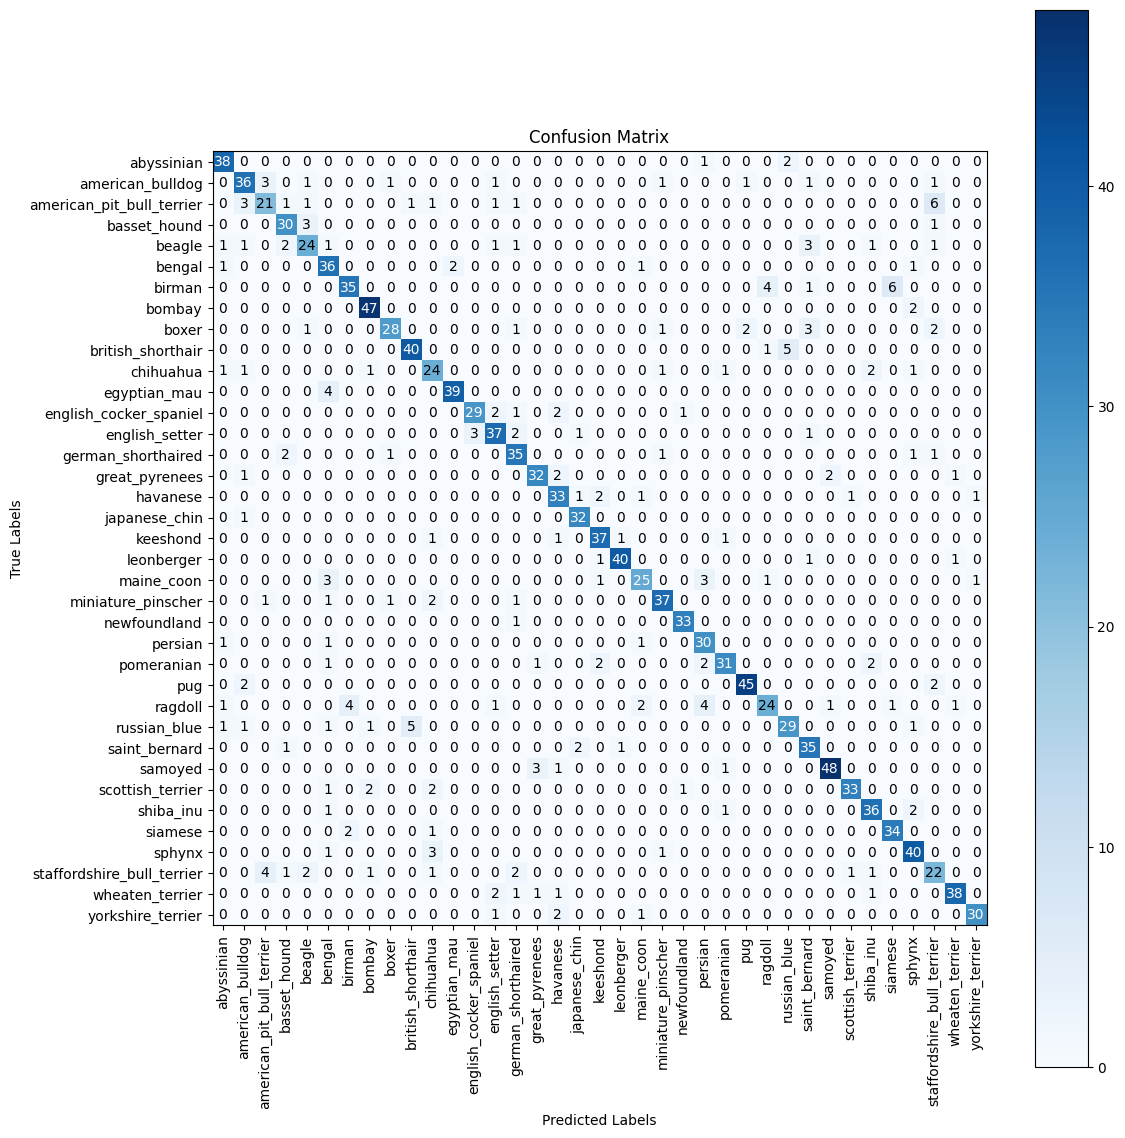

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
resnet = get_resnet(num_classes=37).to(device)
# Falls ihr hier etwas ändert, bitte darauf achten, dass diese If-Abfrage nicht entfernt wird.
# Ansonsten wird das auto-grading zu lange dauern und abbrechen.
if not is_grading:
    train_and_evaluate(resnet, num_epochs=10, device=device, lr=0.00001)  # smaller lr for finetuning
    plot_confusion_matrix(test_dataset, resnet, animal_names, device)

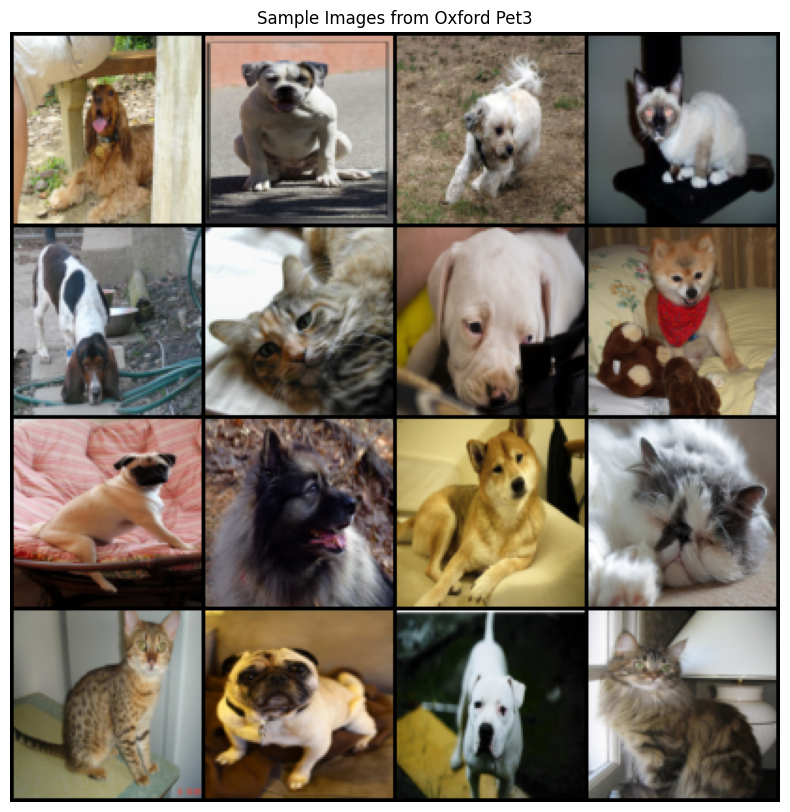

Labels (True | Predicted):
english_   | english_     american   | american     havanese   | havanese     siamese    | siamese      
basset_h   | basset_h     maine_co   | bengal       american   | american     pomerani   | shiba_in     
pug        | pug          keeshond   | keeshond     shiba_in   | shiba_in     persian    | persian      
egyptian   | egyptian     pug        | pug          american   | american     maine_co   | maine_co     


In [53]:
# Qualitative results, restart this cell for different results
show_images_with_predictions(test_dataset, resnet, num_images=16)

# Zusammenfassung
Dies war das Notebook über CNNs. Wenn man eines mitnehmen möchte, dann dass Transfer Learning die Performance extrem verbessern kann. Allerdings waren bei uns die Aufgaben auch ähnlich (die Modelle wurden auch auf Multi-Klassifikation vortrainiert, insbesondere auf tausenden verschiedenen Tierklassen), deshalb kann man solch eine Verbesserung nicht immer erwarten. Da das Interface von Pytorch allerdings so einfach ist um vortrainierte Modelle zu laden, lohnt es sich auf jeden Fall es auszuprobieren.

Vergesst nicht die Theorie Aufgabe auf dem Übungsblatt!